In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import json
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
import lightgbm as lgb
from openai import AzureOpenAI

warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
print(df.info())
print(df.shape)
print(df.describe().T)

cat_cols = df.select_dtypes(include='object').columns
print(df[cat_cols].describe().T)

for col in cat_cols:
    print(df[col].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
print(df['TotalCharges'].str.strip().eq('').sum())

11


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

In [6]:
# Preserve real customerID and unencoded categoricals
cat_cols = df.select_dtypes(include='object').columns.drop(['customerID', 'Churn'])
original_df = df[['customerID'] + list(cat_cols)].copy()

# Encode categorical features
encoders = {col: LabelEncoder().fit(df[col]) for col in cat_cols}
df[cat_cols] = df[cat_cols].apply(lambda col: encoders[col.name].transform(col))

# Standardize features
features = df.drop(columns=['customerID', 'Churn'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

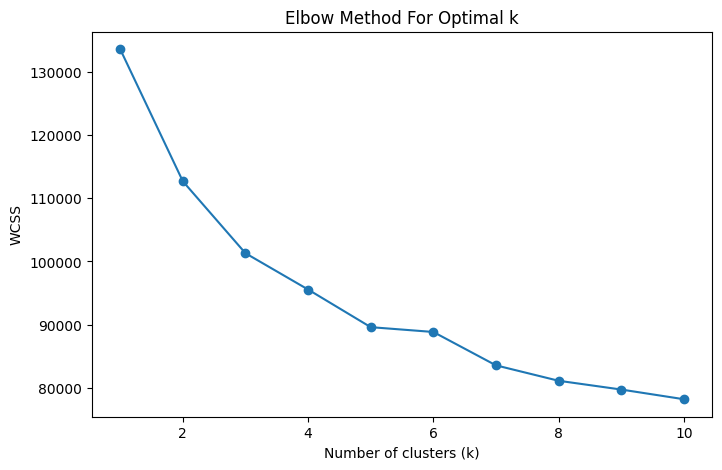

In [7]:
#Choosing k from Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

In [8]:
# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

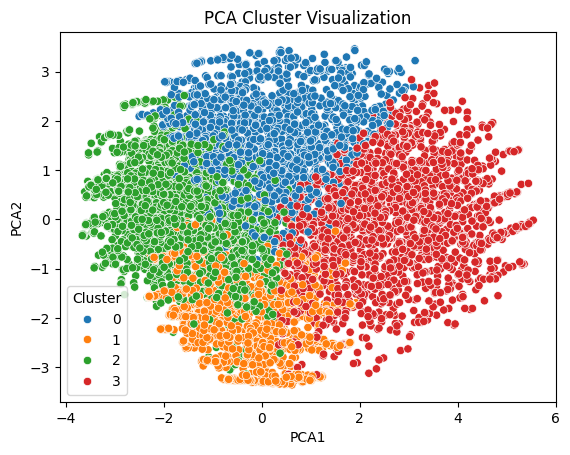

In [9]:
# PCA for 2D visualization only
pca = PCA(n_components=2)
df[['PCA1', 'PCA2']] = pca.fit_transform(scaled_features)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('PCA Cluster Visualization')
plt.show()
df.drop(columns=['PCA1', 'PCA2'], inplace=True)

In [10]:
# Churn encoding
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Cluster-wise numeric & categorical summaries
cat_original = df[cat_cols].copy()
cat_original['Cluster'] = df['Cluster']
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df.groupby('Cluster')[num_cols].mean().round(2).to_csv('numeric_summary.csv')
cat_original.groupby('Cluster').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_csv('categorical_summary.csv')


In [11]:
# Train-test split
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_model = X_train.drop(columns=['Cluster'], errors='ignore')
X_test_model = X_test.drop(columns=['Cluster'], errors='ignore')

In [12]:
# LightGBM hyperparameter tuning
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [20, 40],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [0, 5, 10]
}
lgb_clf = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)
roc_auc = make_scorer(roc_auc_score, needs_proba=True)
search = RandomizedSearchCV(lgb_clf, param_dist, n_iter=30, scoring=roc_auc, cv=3, verbose=2, n_jobs=-1, random_state=42)
search.fit(X_train_model, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 997, number of negative: 2753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.6, 0.8, 1.0],
                                        'bagging_freq': [0, 5, 10],
                                        'feature_fraction': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10],
                                        'min_child_samples': [20, 40],
                                        'num_leaves': [31, 50, 70]},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, response_method='predict_proba'),
                   verbose=2)

In [13]:
# Evaluation
best_model = search.best_estimator_
y_prob_test = best_model.predict_proba(X_test_model)[:,1]
y_pred_test = (y_prob_test >= 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
print("Final Test ROC AUC:", roc_auc_score(y_test, y_prob_test))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1033
           1       0.60      0.66      0.63       374

    accuracy                           0.79      1407
   macro avg       0.73      0.75      0.74      1407
weighted avg       0.80      0.79      0.79      1407

Final Test ROC AUC: 0.8378004462367539


Generating SHAP summary for Cluster 3 with 1433 samples...


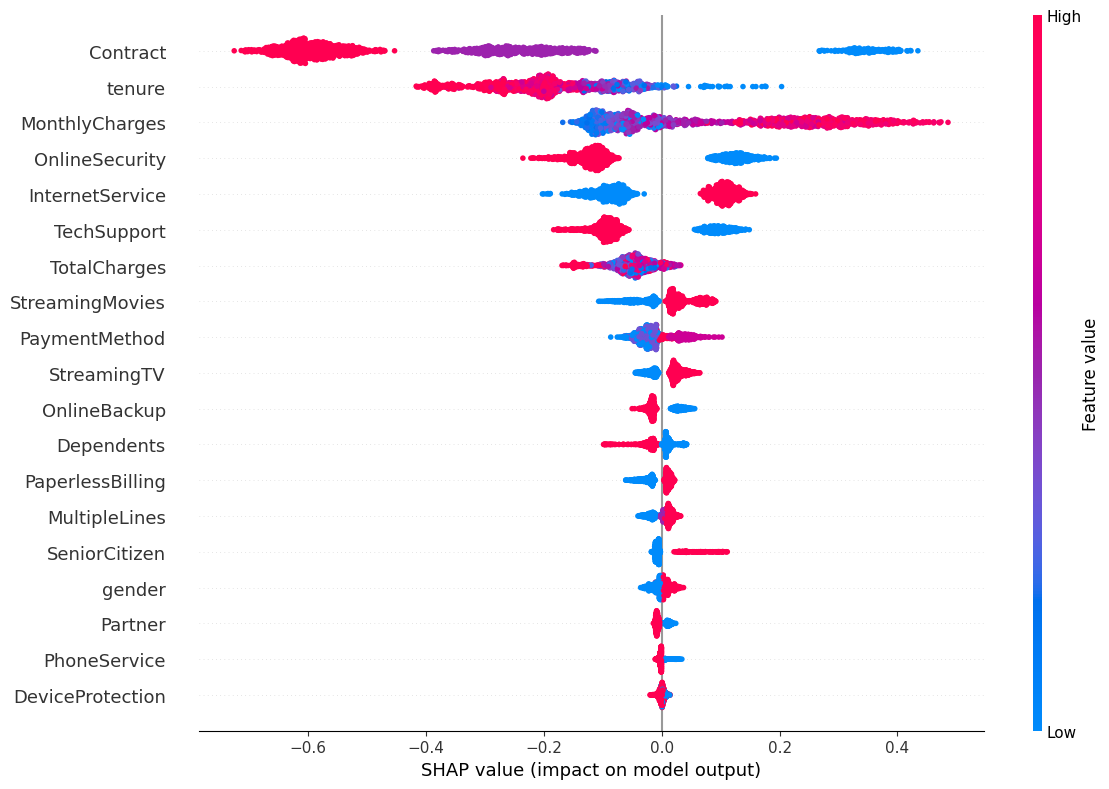

Generating SHAP summary for Cluster 2 with 1752 samples...


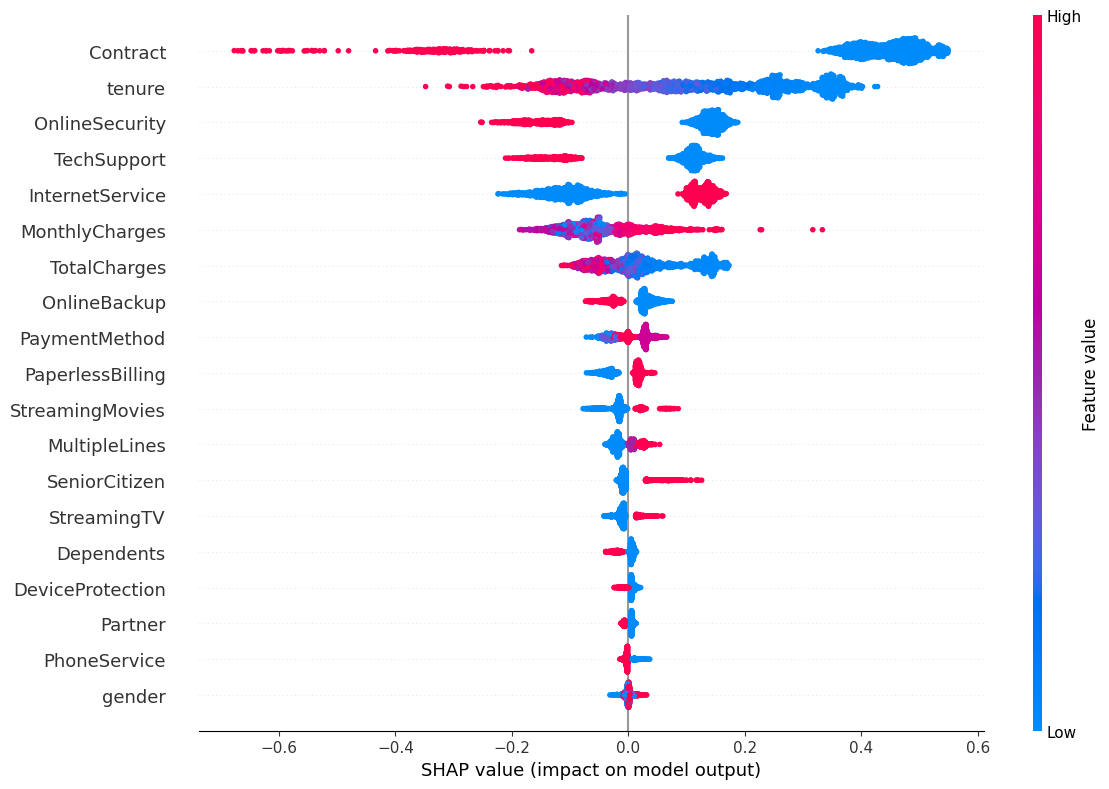

Generating SHAP summary for Cluster 0 with 1228 samples...


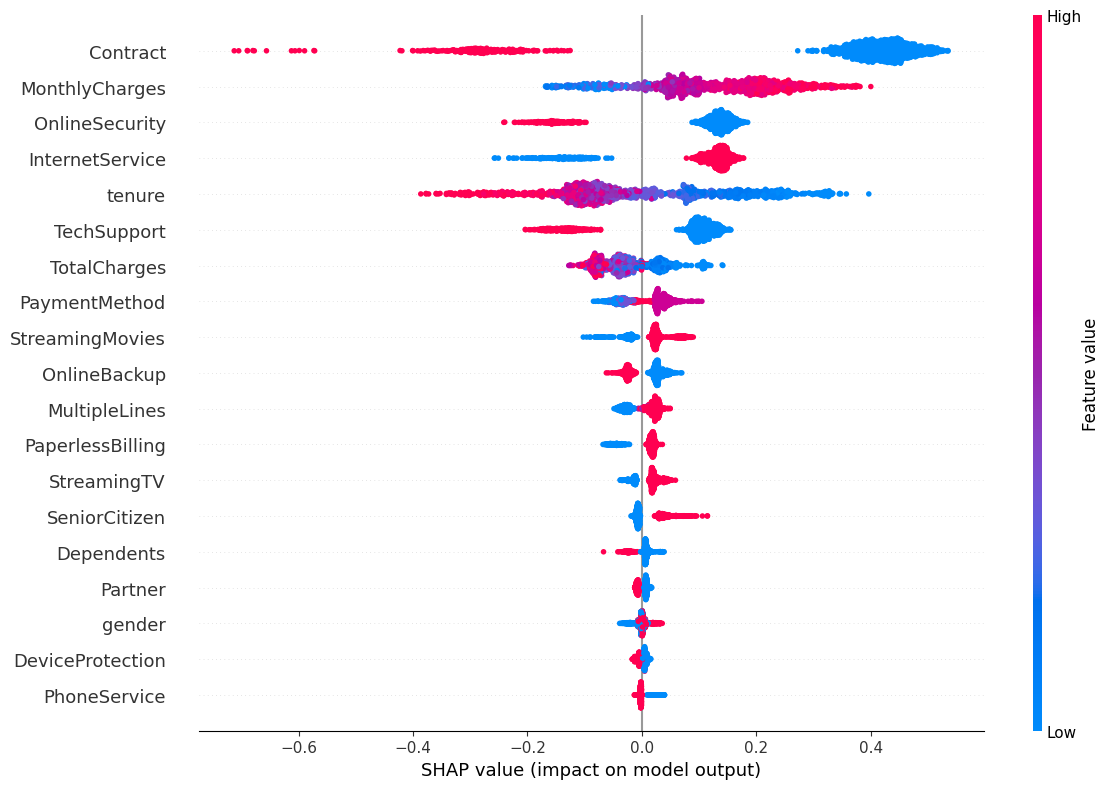

Generating SHAP summary for Cluster 1 with 1212 samples...


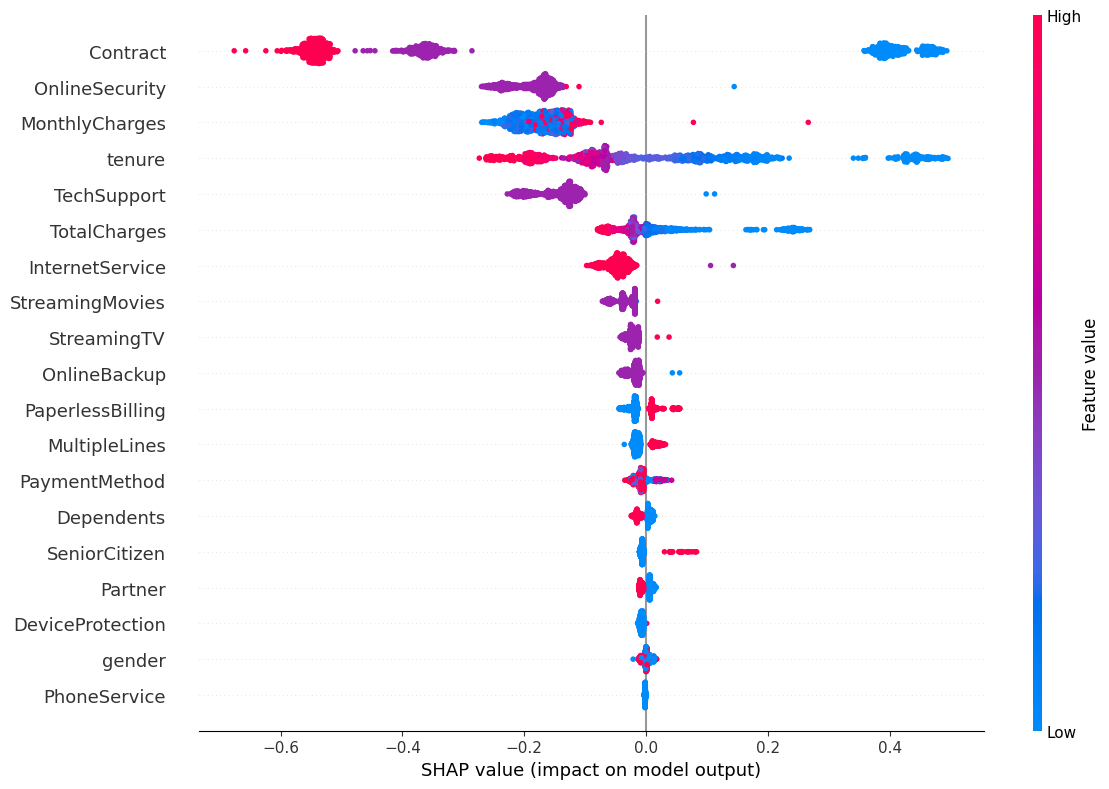

In [14]:
# SHAP by cluster
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_model)
shap_vals_pos_class = shap_values[1]
train_clusters = df.loc[X_train_model.index, 'Cluster']

for cluster_id in train_clusters.unique():
    idx = train_clusters[train_clusters == cluster_id].index
    pos = X_train_model.index.get_indexer_for(idx)
    print(f"Generating SHAP summary for Cluster {cluster_id} with {len(idx)} samples...")
    shap.summary_plot(shap_vals_pos_class[pos], X_train_model.loc[idx], show=True, plot_size=(12, 8))


In [15]:
# Segment summary table
cluster_summary_df = pd.DataFrame({
    "Cluster": [0, 1, 2, 3],
    "Segment Name": [
        "Price-Sensitive Flexi Churners",
        "Underserved Essentials Churners",
        "Premium Experience Expecters",
        "Newcomer Value Skeptics"
    ],
    "Persona": [
        "Budget-conscious users on month-to-month plans, new or mid-tenure, churn if prices are high.",
        "Users lacking TechSupport/OnlineSecurity, feel vulnerable or unsupported, churn from gaps.",
        "Demanding high-end users with strong Internet use but low satisfaction, sensitive to quality.",
        "New joiners with high bills, unsure of service value, may churn quickly."
    ],
    "Email Campaign Focus": [
        "“Lock in Savings Today” - “Get More for Less” bundle - Loyalty benefits for staying 3+ months",
        "“Protect Your Digital Life” - “Stay Safer, Worry Less” - Highlight value of support add-ons",
        "“We’re Listening” check-in - “Your Premium Experience, Upgraded” - VIP support invitation",
        "“See the Full Value” guide series - “You’ve Earned This” loyalty unlock - “Why Others Stay” stories"
    ],
    "Retention Strategy (Offers & Coupons)": [
        "🎁 3-month discount (10–15%) for switching to 12-month plan 💡 Bundled plans with waived setup 🏷️ First-month half-off promo",
        "🔒 Free 1-month TechSupport trial 🛡️ Security pack at 50% for 6 months 📞 24/7 priority support upgrade coupon",
        "🚀 VIP onboarding with live concierge 🎟️ $20 loyalty credit ⚡ Early access to premium plans or speed upgrades",
        "🎉 $10 welcome loyalty credit 💰 Cashback after 90 days 🎁 Free upgrade to streaming or data pack for 1 month"
    ],
    "Top 3 Churn Drivers (SHAP)": [
        "1. Month-to-month contract 2. High monthly charges 3. Low tenure",
        "1. No OnlineSecurity 2. No TechSupport 3. Month-to-month contract",
        "1. No TechSupport 2. Low tenure 3. High Internet service level",
        "1. Month-to-month contract 2. Low tenure 3. High monthly charges"
    ]
})

In [16]:
# Azure OpenAI setup (update credentials)
client = AzureOpenAI(
    api_version="VERSION",
    azure_endpoint="YOURENDPOINT.services.ai.azure.com",
    api_key="YOURKEY",
)

def generate_messages(segment_name, persona, churn_drivers):
    prompt = (
        f"You are a marketing expert crafting customer retention messages for a telecom company.\n"
        f"Segment: {segment_name}\nPersona: {persona}\n"
        f"Top 3 churn drivers: {churn_drivers}\n\n"
        f"Generate a persuasive email campaign and short offer message."
    )
    response = client.chat.completions.create(
        model="gpt-35-churn",
        messages=[
            {"role": "system", "content": "You are a helpful customer churn analyst and marketing advisor."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=400,
        temperature=0.8
    )
    return response.choices[0].message.content.strip()

# Message generation per cluster
cluster_messages = {}
for _, row in cluster_summary_df.iterrows():
    print(f"Generating GPT message for Cluster {row['Cluster']}")
    msg = generate_messages(row['Segment Name'], row['Persona'], row['Top 3 Churn Drivers (SHAP)'])
    cluster_messages[row['Cluster']] = msg


Generating GPT message for Cluster 0
Generating GPT message for Cluster 1
Generating GPT message for Cluster 2
Generating GPT message for Cluster 3


In [17]:
# Map messages and simulate A/B testing
df['Retention_Messages'] = df['Cluster'].map(cluster_messages)
np.random.seed(42)
df['AB_Group'] = np.random.choice(['A', 'B'], size=len(df))
df['Offer_Message'] = df.apply(lambda x: "Baseline offer message" if x['AB_Group']=='A' else cluster_messages[x['Cluster']], axis=1)

def simulate_churn(row):
    base, improved = 0.3, 0.2
    return np.random.choice([0,1], p=[1-improved, improved]) if row['AB_Group']=='B' else np.random.choice([0,1], p=[1-base, base])

df['Simulated_Churn'] = df.apply(simulate_churn, axis=1)

# Assign artificial numeric ID & join original fields
df = df.reset_index(drop=True)
df['CustomerIndex'] = df.index
final_df = pd.concat([original_df.reset_index(drop=True), df.drop(columns=['customerID'] + list(cat_cols), errors='ignore')], axis=1)

In [18]:
# Group-level summary
summary_df = final_df.groupby(['Cluster', 'AB_Group']).agg(
    Customers=('CustomerIndex', 'count'),
    Churn_Rate=('Simulated_Churn', 'mean')
).reset_index()
summary_df['Churn_Rate'] = (summary_df['Churn_Rate'] * 100).round(2)

# Export outputs
final_df.to_csv('telco_churn_full_data.csv', index=False)
summary_df.to_csv('telco_churn_ab_summary.csv', index=False)
with open('cluster_retention_messages.json', 'w') as f:
    json.dump(cluster_messages, f, indent=2)

print("\n✅ Final data exported with original customer IDs and readable categories.")


✅ Final data exported with original customer IDs and readable categories.
